# Naive Baseline: LogisticRegression vs RandomForestClassifier

Сравнение двух моделей для классификации типа совпадения RFQ–Supplier (`match`, `weak_match`, `related`, `no_match`) на основе текстовых признаков (TF-IDF).

Подход:
1. Общая предобработка и разбиение данных
2. Подбор гиперпараметров (`GridSearchCV` с `GroupKFold`) для каждой модели
3. Сравнение лучших конфигураций на валидации
4. Финальная оценка лучшей модели на тестовой выборке

Данный подход я назвал наивным, так как тут нет осбобой предобработки данных - они не сбалансированы по классам и взяты просто 10к записей без какой-то особой логики.

Так же используется обычное текстовое сравнение, вместо семантической схожести, что важно в моем случае, так как данные на разных языках (до 26 языков).

Возможно следует `weak_match` совместить с `related` - так как они достаточно схожи друг с другом и 3 классов должно быть более чем достаточно. 

---
## 1. Импорты и настройки

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from pathlib import Path
from time import time

from sklearn.model_selection import (
    GroupShuffleSplit,
    GroupKFold,
    GridSearchCV,
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    f1_score,
    make_scorer,
)

import matplotlib.pyplot as plt
import seaborn as sns

---
## 2. Загрузка данных

In [5]:
data_path = Path("dataset/result_dataset_1k.csv")
df = pd.read_csv(data_path)

print("Форма датасета:", df.shape)
print("Колонки:", df.columns)
print("\nРаспределение классов:")
print(df["match_type"].value_counts())

Форма датасета: (1000, 15)
Колонки: Index(['rfq_id', 'rfq_title', 'rfq_description', 'quantity',
       'delivery_location', 'rfq_supplier_types', 'supplier_name',
       'supplier_country', 'distribution_area', 'supplier_description',
       'supplier_types', 'products', 'product_categories', 'keywords',
       'match_type'],
      dtype='object')

Распределение классов:
match_type
no_match      548
match         331
weak_match     73
related        48
Name: count, dtype: int64


По распределение классов можно заметить, что они не сбалансированы, если `no_match` еще хоть как-то баоансирует с `match`, то `weak_match` и `related` вообще разного порядка и скорее всего модель не сможет научиться их отличать, а стабильно будет их пропускать.

---
## 3. Предобработка

Очистка полей в формате PostgreSQL-массивов (фигурные скобки), заполнение пропусков, формирование текстовых признаков `rfq_text` и `supplier_text`.

NOTE: 

Сейчас это брутфорс-подъод, и есть интерес посмотреть, что будет если взять данные без как-то особой обработки.
Но вообще следовало бы:

1.`delivery_location` стоит смотреть в пересечении с `supplier_country` и `distribution_area`, а не как просто текстовые признаки (возможно даже учитывать дистанцию между этими областями) \
2. `rfq_supplier_types` также стоит смотреть в пересечении с `supplier_types`

In [30]:
def clean_array_field(s: str) -> str:
    if pd.isna(s):
        return ""
    s = str(s).strip()
    if s.startswith("{") and s.endswith("}"):
        s = s[1:-1]

    return s.replace(",", ", ")

array_columns = [
    "rfq_supplier_types", "supplier_types", "products", "product_categories", "keywords"
]
for col in array_columns:
    if col in df.columns:
        df[col] = df[col].apply(clean_array_field)

text_columns = [
    "rfq_title", "rfq_description", "delivery_location", "quantity",
    "rfq_supplier_types", "supplier_name", "supplier_country", "distribution_area",
    "supplier_description", "supplier_types", "products", "product_categories", "keywords",
]
for col in text_columns:
    if col in df.columns:
        df[col] = df[col].fillna("").astype(str)

flag = False
nan_counts = df.isna().sum()
if nan_counts.sum() > 0:
    print("Пропуски по колонкам (до заполнения)")
    for col in df.columns:
        if nan_counts[col] > 0:
            print(f"  {col}: {nan_counts[col]}")    

In [13]:
df["rfq_text"] = (
    df["rfq_title"] + " "
    + df["rfq_description"] + " "
    + df["delivery_location"] + " "
    + df["quantity"] + " "
    + df["rfq_supplier_types"]
)

df["supplier_text"] = (
    df["supplier_name"] + " "
    + df["supplier_description"] + " "
    + df["products"] + " "
    + df["product_categories"] + " "
    + df["keywords"] + " "
    + df["distribution_area"] + " "
    + df["supplier_country"] + " "
    + df["supplier_types"]
)

print("Текстовые признаки сформированы.")
df[["rfq_text", "supplier_text", "match_type"]].head(5)

Текстовые признаки сформированы.


,rfq_text,supplier_text,match_type
0,electric kick scooters e-scooters New family s...,Yatdim GmbH Yatdim GmbH – Your Partner for E-M...,weak_match
1,electric kick scooters e-scooters New family s...,Erler Mobile GmbH Erler Mobile produces electr...,related
2,electric kick scooters e-scooters New family s...,Yatdim GmbH Yatdim GmbH – Your Partner for E-M...,related
3,electric kick scooters e-scooters New family s...,Sauter Engineering + Design GmbH Sauter Engine...,no_match
4,electric kick scooters e-scooters New family s...,EVENTTRUCK MASTERS Event Truck Masters is a co...,no_match


---
## 4. Разбиение на обучающую, валидационную и тестовую выборки (60 / 20 / 20)

**GroupShuffleSplit** по `rfq_id`: все строки одного RFQ попадают в одну выборку с целью избежать data leakage между сетами

In [ ]:
y = df["match_type"]
groups = df["rfq_id"]
feature_columns = ["rfq_text", "supplier_text"]

# 60% на train, 20% на val, 20% на test
gss1 = GroupShuffleSplit(n_splits=1, train_size=0.6, random_state=42)
train_idx, temp_idx = next(gss1.split(df, y, groups))

gss2 = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=43)
val_idx, test_idx = next(gss2.split(
    df.iloc[temp_idx], y.iloc[temp_idx], groups.iloc[temp_idx]
))
val_idx = np.array(temp_idx)[val_idx]
test_idx = np.array(temp_idx)[test_idx]

X_train = df.loc[train_idx, feature_columns]
y_train = y.iloc[train_idx]

X_val = df.loc[val_idx, feature_columns]
y_val = y.iloc[val_idx]

X_test = df.loc[test_idx, feature_columns]
y_test = y.iloc[test_idx]

print(f"Train: {len(X_train)},  Val: {len(X_val)},  Test: {len(X_test)}")
print(f"\nРаспределение классов (train):\n{y_train.value_counts()}")
print(f"\nРаспределение классов (val):\n{y_val.value_counts()}")
print(f"\nРаспределение классов (test):\n{y_test.value_counts()}")

Train: 575,  Val: 225,  Test: 200

Распределение классов (train):
match_type
no_match      391
match         134
weak_match     34
related        16
Name: count, dtype: int64

Распределение классов (val):
match_type
match         126
no_match       81
weak_match     11
related         7
Name: count, dtype: int64

Распределение классов (test):
match_type
no_match      76
match         71
weak_match    28
related       25
Name: count, dtype: int64



О чем я и писал выше, про несбалансированные данные по классам, На train видно слишком много `no_match`.

---
## 5. Подготовка к подбору гиперпараметров

Общий `ColumnTransformer` для TF-IDF. Подбор ведётся через `GridSearchCV` с `GroupKFold`,
метрика — **macro F1**, чтобы учесть дисбаланс классов.

In [18]:
column_transformer = ColumnTransformer(
    [
        ("rfq_tfidf", TfidfVectorizer(max_features=5000), "rfq_text"),
        ("supplier_tfidf", TfidfVectorizer(max_features=5000), "supplier_text"),
    ],
    remainder="drop",
)

scorer = make_scorer(f1_score, average="macro", zero_division=0)
cv = GroupKFold(n_splits=3)
train_groups = groups.iloc[train_idx]

results = {}

---
## 6. LogisticRegression — подбор гиперпараметров

In [ ]:
lr_pipeline = Pipeline([
    ("features", column_transformer),
    ("clf", LogisticRegression(max_iter=1000, random_state=42)),
])

lr_param_grid = {
    "clf__C": [0.01, 0.1, 1.0, 10.0],
    "clf__penalty": ["l1", "l2"],
    "clf__solver": ["saga"],
    "clf__class_weight": ["balanced", None],
}

print("Подбор гиперпараметров для LogisticRegression...")
t0 = time()

lr_search = GridSearchCV(
    lr_pipeline,
    lr_param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True,
)
lr_search.fit(X_train, y_train, groups=train_groups)

lr_time = time() - t0
print(f"\nЗавершено за {lr_time:.1f} сек.")
print(f"Лучшие параметры: {lr_search.best_params_}")
print(f"Лучший CV macro-F1: {lr_search.best_score_:.4f}")

lr_val_pred = lr_search.best_estimator_.predict(X_val)
lr_val_acc = accuracy_score(y_val, lr_val_pred)
lr_val_f1 = f1_score(y_val, lr_val_pred, average="macro", zero_division=0)
print(f"\nValidation accuracy: {lr_val_acc:.4f}")
print(f"Validation macro-F1: {lr_val_f1:.4f}")
print("\nValidation — classification report:")
print(classification_report(y_val, lr_val_pred, zero_division=0))

results["LogisticRegression"] = {
    "best_params": lr_search.best_params_,
    "cv_f1": lr_search.best_score_,
    "val_acc": lr_val_acc,
    "val_f1": lr_val_f1,
    "estimator": lr_search.best_estimator_,
    "time_sec": lr_time,
}

Подбор гиперпараметров для LogisticRegression...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Завершено за 6.6 сек.
Лучшие параметры: {'clf__C': 0.01, 'clf__class_weight': 'balanced', 'clf__penalty': 'l1', 'clf__solver': 'saga'}
Лучший CV macro-F1: nan

Validation accuracy: 0.3600
Validation macro-F1: 0.1324

Validation — classification report:
              precision    recall  f1-score   support

       match       0.00      0.00      0.00       126
    no_match       0.36      1.00      0.53        81
     related       0.00      0.00      0.00         7
  weak_match       0.00      0.00      0.00        11

    accuracy                           0.36       225
   macro avg       0.09      0.25      0.13       225
weighted avg       0.13      0.36      0.19       225



---
## 7. RandomForestClassifier — подбор гиперпараметров

In [20]:
rf_pipeline = Pipeline([
    ("features", column_transformer),
    ("clf", RandomForestClassifier(random_state=42)),
])

rf_param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [None, 20, 40],
    "clf__min_samples_split": [2, 5],
    "clf__class_weight": ["balanced", "balanced_subsample", None],
}

print("Подбор гиперпараметров для RandomForestClassifier...")
t0 = time()

rf_search = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True,
)
rf_search.fit(X_train, y_train, groups=train_groups)

rf_time = time() - t0
print(f"\nЗавершено за {rf_time:.1f} сек.")
print(f"Лучшие параметры: {rf_search.best_params_}")
print(f"Лучший CV macro-F1: {rf_search.best_score_:.4f}")

rf_val_pred = rf_search.best_estimator_.predict(X_val)
rf_val_acc = accuracy_score(y_val, rf_val_pred)
rf_val_f1 = f1_score(y_val, rf_val_pred, average="macro", zero_division=0)
print(f"\nValidation accuracy: {rf_val_acc:.4f}")
print(f"Validation macro-F1: {rf_val_f1:.4f}")
print("\nValidation — classification report:")
print(classification_report(y_val, rf_val_pred, zero_division=0))

results["RandomForestClassifier"] = {
    "best_params": rf_search.best_params_,
    "cv_f1": rf_search.best_score_,
    "val_acc": rf_val_acc,
    "val_f1": rf_val_f1,
    "estimator": rf_search.best_estimator_,
    "time_sec": rf_time,
}

Подбор гиперпараметров для RandomForestClassifier...
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Завершено за 3.7 сек.
Лучшие параметры: {'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Лучший CV macro-F1: nan

Validation accuracy: 0.3600
Validation macro-F1: 0.1385

Validation — classification report:
              precision    recall  f1-score   support

       match       0.67      0.02      0.03       126
    no_match       0.36      0.98      0.52        81
     related       0.00      0.00      0.00         7
  weak_match       0.00      0.00      0.00        11

    accuracy                           0.36       225
   macro avg       0.26      0.25      0.14       225
weighted avg       0.50      0.36      0.21       225



---
## 8. Сравнение моделей

In [32]:
comparison = pd.DataFrame({
    name: {
        "CV macro-F1": f"{r['cv_f1']:.4f}",
        "Val accuracy": f"{r['val_acc']:.4f}",
        "Val macro-F1": f"{r['val_f1']:.4f}",
        "Best params": str(r["best_params"]),
        "Fit time (sec)": f"{r['time_sec']:.1f}",
    }
    for name, r in results.items()
}).T

print("=" * 70)
print("СРАВНЕНИЕ МОДЕЛЕЙ")
print("=" * 70)
display(comparison)

best_model_name = max(results, key=lambda k: results[k]["val_f1"])
print(f"\nЛучшая модель по Val macro-F1: {best_model_name}")
print(f"    Val macro-F1 = {results[best_model_name]['val_f1']:.4f}")
print(f"    Val accuracy = {results[best_model_name]['val_acc']:.4f}")

best_pipeline = results[best_model_name]["estimator"]

СРАВНЕНИЕ МОДЕЛЕЙ


,CV macro-F1,Val accuracy,Val macro-F1,Best params,Fit time (sec)
LogisticRegression,nan,0.3600,0.1324,"{'clf__C': 0.01, 'clf__class_weight': 'balance...",6.6
RandomForestClassifier,nan,0.3600,0.1385,"{'clf__class_weight': 'balanced', 'clf__max_de...",3.7



Лучшая модель по Val macro-F1: RandomForestClassifier
    Val macro-F1 = 0.1385
    Val accuracy = 0.3600


---
## 9. Финальная оценка лучшей модели на тестовой выборке

In [33]:
y_pred = best_pipeline.predict(X_test)

print(f"Лучшая модель: {best_model_name}")
print(f"Лучшие параметры: {results[best_model_name]['best_params']}")
print()
print("Test — classification report:")
print(classification_report(y_test, y_pred, zero_division=0))
print(f"Test accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Test macro-F1:  {f1_score(y_test, y_pred, average='macro', zero_division=0):.4f}")

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix (test):")
print(cm)

Лучшая модель: RandomForestClassifier
Лучшие параметры: {'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}

Test — classification report:
              precision    recall  f1-score   support

       match       0.00      0.00      0.00        71
    no_match       0.39      0.99      0.56        76
     related       0.00      0.00      0.00        25
  weak_match       0.67      0.07      0.13        28

    accuracy                           0.39       200
   macro avg       0.26      0.26      0.17       200
weighted avg       0.24      0.39      0.23       200

Test accuracy:  0.3850
Test macro-F1:  0.1711

Confusion matrix (test):
[[ 0 71  0  0]
 [ 0 75  0  1]
 [ 0 25  0  0]
 [ 3 23  0  2]]


---
## 10. Визуализация

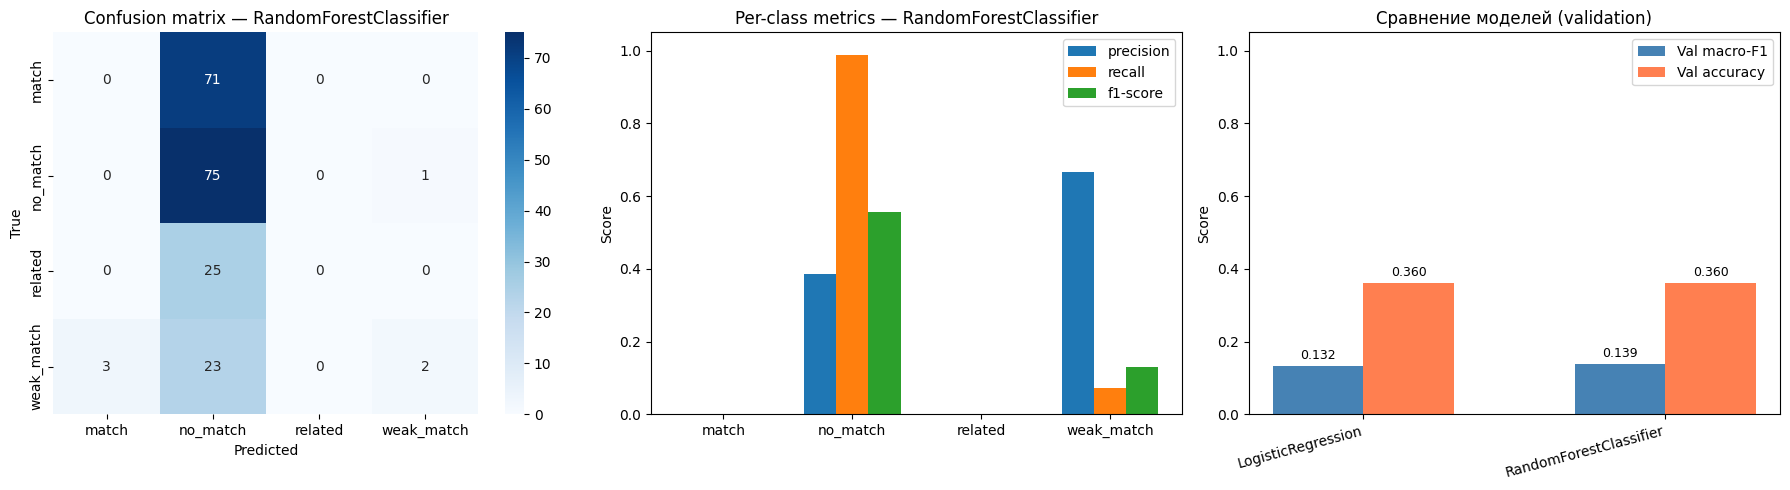

In [34]:
labels = sorted(y.unique())

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- 1. Confusion matrix лучшей модели ---
sns.heatmap(
    cm, xticklabels=labels, yticklabels=labels,
    annot=True, fmt="d", cmap="Blues", ax=axes[0],
)
axes[0].set_title(f"Confusion matrix — {best_model_name}")
axes[0].set_ylabel("True")
axes[0].set_xlabel("Predicted")

# --- 2. Per-class metrics лучшей модели ---
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
metrics = ["precision", "recall", "f1-score"]
x = np.arange(len(labels))
width = 0.25
for i, m in enumerate(metrics):
    vals = [report[l].get(m, 0) for l in labels]
    axes[1].bar(x + i * width, vals, width, label=m)
    
axes[1].set_xticks(x + width)
axes[1].set_xticklabels(labels)
axes[1].set_ylabel("Score")
axes[1].set_title(f"Per-class metrics — {best_model_name}")
axes[1].legend()
axes[1].set_ylim(0, 1.05)

# --- 3. Сравнение моделей: Val macro-F1 и Val accuracy ---
model_names = list(results.keys())
val_f1s = [results[n]["val_f1"] for n in model_names]
val_accs = [results[n]["val_acc"] for n in model_names]

x2 = np.arange(len(model_names))
axes[2].bar(x2 - 0.15, val_f1s, 0.3, label="Val macro-F1", color="steelblue")
axes[2].bar(x2 + 0.15, val_accs, 0.3, label="Val accuracy", color="coral")
axes[2].set_xticks(x2)
axes[2].set_xticklabels(model_names, rotation=15, ha="right")
axes[2].set_ylabel("Score")
axes[2].set_title("Сравнение моделей (validation)")
axes[2].legend()
axes[2].set_ylim(0, 1.05)

for i, (f1, acc) in enumerate(zip(val_f1s, val_accs)):
    axes[2].text(i - 0.15, f1 + 0.02, f"{f1:.3f}", ha="center", fontsize=9)
    axes[2].text(i + 0.15, acc + 0.02, f"{acc:.3f}", ha="center", fontsize=9)

plt.tight_layout()
plt.show()

---
## Выводы

### Результаты

**Лучшая модель по Val macro-F1:** RandomForestClassifier (0.1385 vs 0.1324), но разница минимальна.

### Ключевые наблюдения

1. **Обе модели коллапсируют в majority-class prediction.** LogisticRegression предсказывает исключительно `no_match`. RandomForest делает то же самое, но изредка предсказывает `match` (recall 2%) и `weak_match` (recall 7%) — именно это даёт ему незначительное преимущество по macro-F1.

2. **Сильный дисбаланс данных.** В обучающей выборке `no_match` составляет 68% (391 из 575), а `related` — лишь 2.8% (16 объектов). При таком соотношении обе модели обучаются предсказывать доминирующий класс, даже с `class_weight='balanced'`.

3. **Accuracy ~36–39% при 4 классах** — это лишь немного лучше случайного угадывания (25%), и хуже наивного классификатора, который всегда предсказывает самый частый класс в test-е (`no_match`, 38%).

### Причины провала

- **Слабый текстовый сигнал:** конкатенация всех текстовых полей в `rfq_text` и `supplier_text` с последующей TF-IDF векторизацией не порождает признаки, достаточно дискриминативные для разделения 4 классов + разные языки.
- **Нет перекрёстных (interaction) признаков:** модели не видят _связь_ между RFQ и поставщиком — они видят только отдельные TF-IDF вектора. Признаки типа cosine similarity между `rfq_text` и `supplier_text`, пересечение категорий, совпадение стран/регионов могли бы существенно помочь.

### Что можно улучшить

1. **Добавить перекрёстные признаки:** cosine similarity между TF-IDF векторами RFQ и поставщика; пересечение `rfq_supplier_types` ∩ `supplier_types`; совпадение `delivery_location` vs `distribution_area` / `supplier_country`.
2. **Увеличить датасет:** перейти на `dataset_10k.csv` или `dataset_200k.csv` для лучшей представленности миноритарных классов.
3. **Объединить классы:** рассмотреть бинарную классификацию (`match` + `weak_match` → positive, `related` + `no_match` → negative) или трёхклассовую (объединить `weak_match` и `related`).
4. **Попробовать более мощные модели:** GradientBoosting, или предобученные текстовые эмбеддинги (sentence-transformers) вместо TF-IDF.